# Loading Data

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import opendatasets as od
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import re
import string
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense,Input,Embedding,LSTM,Dropout,Conv1D,MaxPooling1D,Dropout,Bidirectional,BatchNormalization

# **Matriz de confusão**
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

In [ ]:
dataset_path = "https://www.kaggle.com/datasets/hijest/genre-classification-dataset-imdb"
od.download(dataset_path)

In [2]:
# Train and test Data
df_train = pd.read_csv("train_data.txt", sep=':::', names=['Title', 'Genre', 'Description'], engine='python')
df_test = pd.read_csv("test_data.txt", sep=':::', names=['Title', 'Description'], engine='python')
solution = pd.read_csv("test_data_solution.txt", sep=':::', names=['Title', 'Genre', 'Description'], engine='python')

df_train.head()

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [3]:
df_train.describe()

,Title,Genre,Description
count,54214,54214,54214
unique,54214,27,54086
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy ...
freq,1,13613,12


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [5]:
print(df_train.isnull().sum())
print(df_train.isna().sum())

Title          0
Genre          0
Description    0
dtype: int64
Title          0
Genre          0
Description    0
dtype: int64


# EDA

In [6]:
# Represent only most common genres
copy = pd.DataFrame(df_train.Genre.value_counts())
sum_other_genres = pd.DataFrame({'count' : copy[copy['count'] < 650].sum().values}, index=['Other'])
copy = pd.concat([sum_other_genres,copy[copy['count'] > 650]]) 

fig = px.pie(copy, values='count', names=copy.index, title='IMDB Most Common Genres')
fig.show()

In [7]:
px.bar(y = df_train.Genre.value_counts(), 
       x = df_train.Genre.value_counts().index,
       labels={'x' : 'Genres',
               'y' : 'Count'},
        title='Genre Count Bar Plot')

It is evident that the predominant genres in movies include drama, accounting for 25% of the total, followed closely by documentary at 24%. Comedy holds a significant share as well, making up 14% of the genres observed, while short films constitute 9%.

Movie genres often share common themes, tones, and narrative elements, which can lead to similarities between certain genres. By grouping these genres together we can have a more reliable dataset.

For example, you might find that thrillers and horror movies tend to have similar plot keywords related to fear, suspense, and danger, suggesting a natural grouping.

So, we are going to be grouping some genres together:

In [8]:
def regroup_genres(data):

    new_genres = {
        "thriller": "thriller/horror",
        "horror": "thriller/horror",
        "war": "action",
        "action": "action",
        "adventure": "action",
        "sci-fi": "sci-fi",
        "western": "western",
        "drama": "drama",
        "romance": "drama",
        "comedy": "comedy",
        "family": "family",
        "animation": "family",
        "music": "music",
        "musical": "music",
        "documentary": "documentary",
        "biography": "documentary",
        "history": "documentary",
        "game-show": "live",
        "sport": "live",
        "reality-tv": "live",
        "news": "live",
        "talk-show": "live",
        "mystery": "police",
        "fantasy": "police",
        "crime": "police",
        "adult": "adult",
        "comedy": "comedy",
        "short": "short"
    }
    data["Genre"] = data["Genre"].str.strip()

    data["Genre"] = data["Genre"].map(new_genres)

    return data

In [9]:
df_train = regroup_genres(df_train)
solution = regroup_genres(solution)

In [10]:
px.bar(y = df_train.Genre.value_counts(), 
       x = df_train.Genre.value_counts().index,
       labels={'x' : 'Genres',
               'y' : 'Count'},
        title='Genre Count Bar Plot')

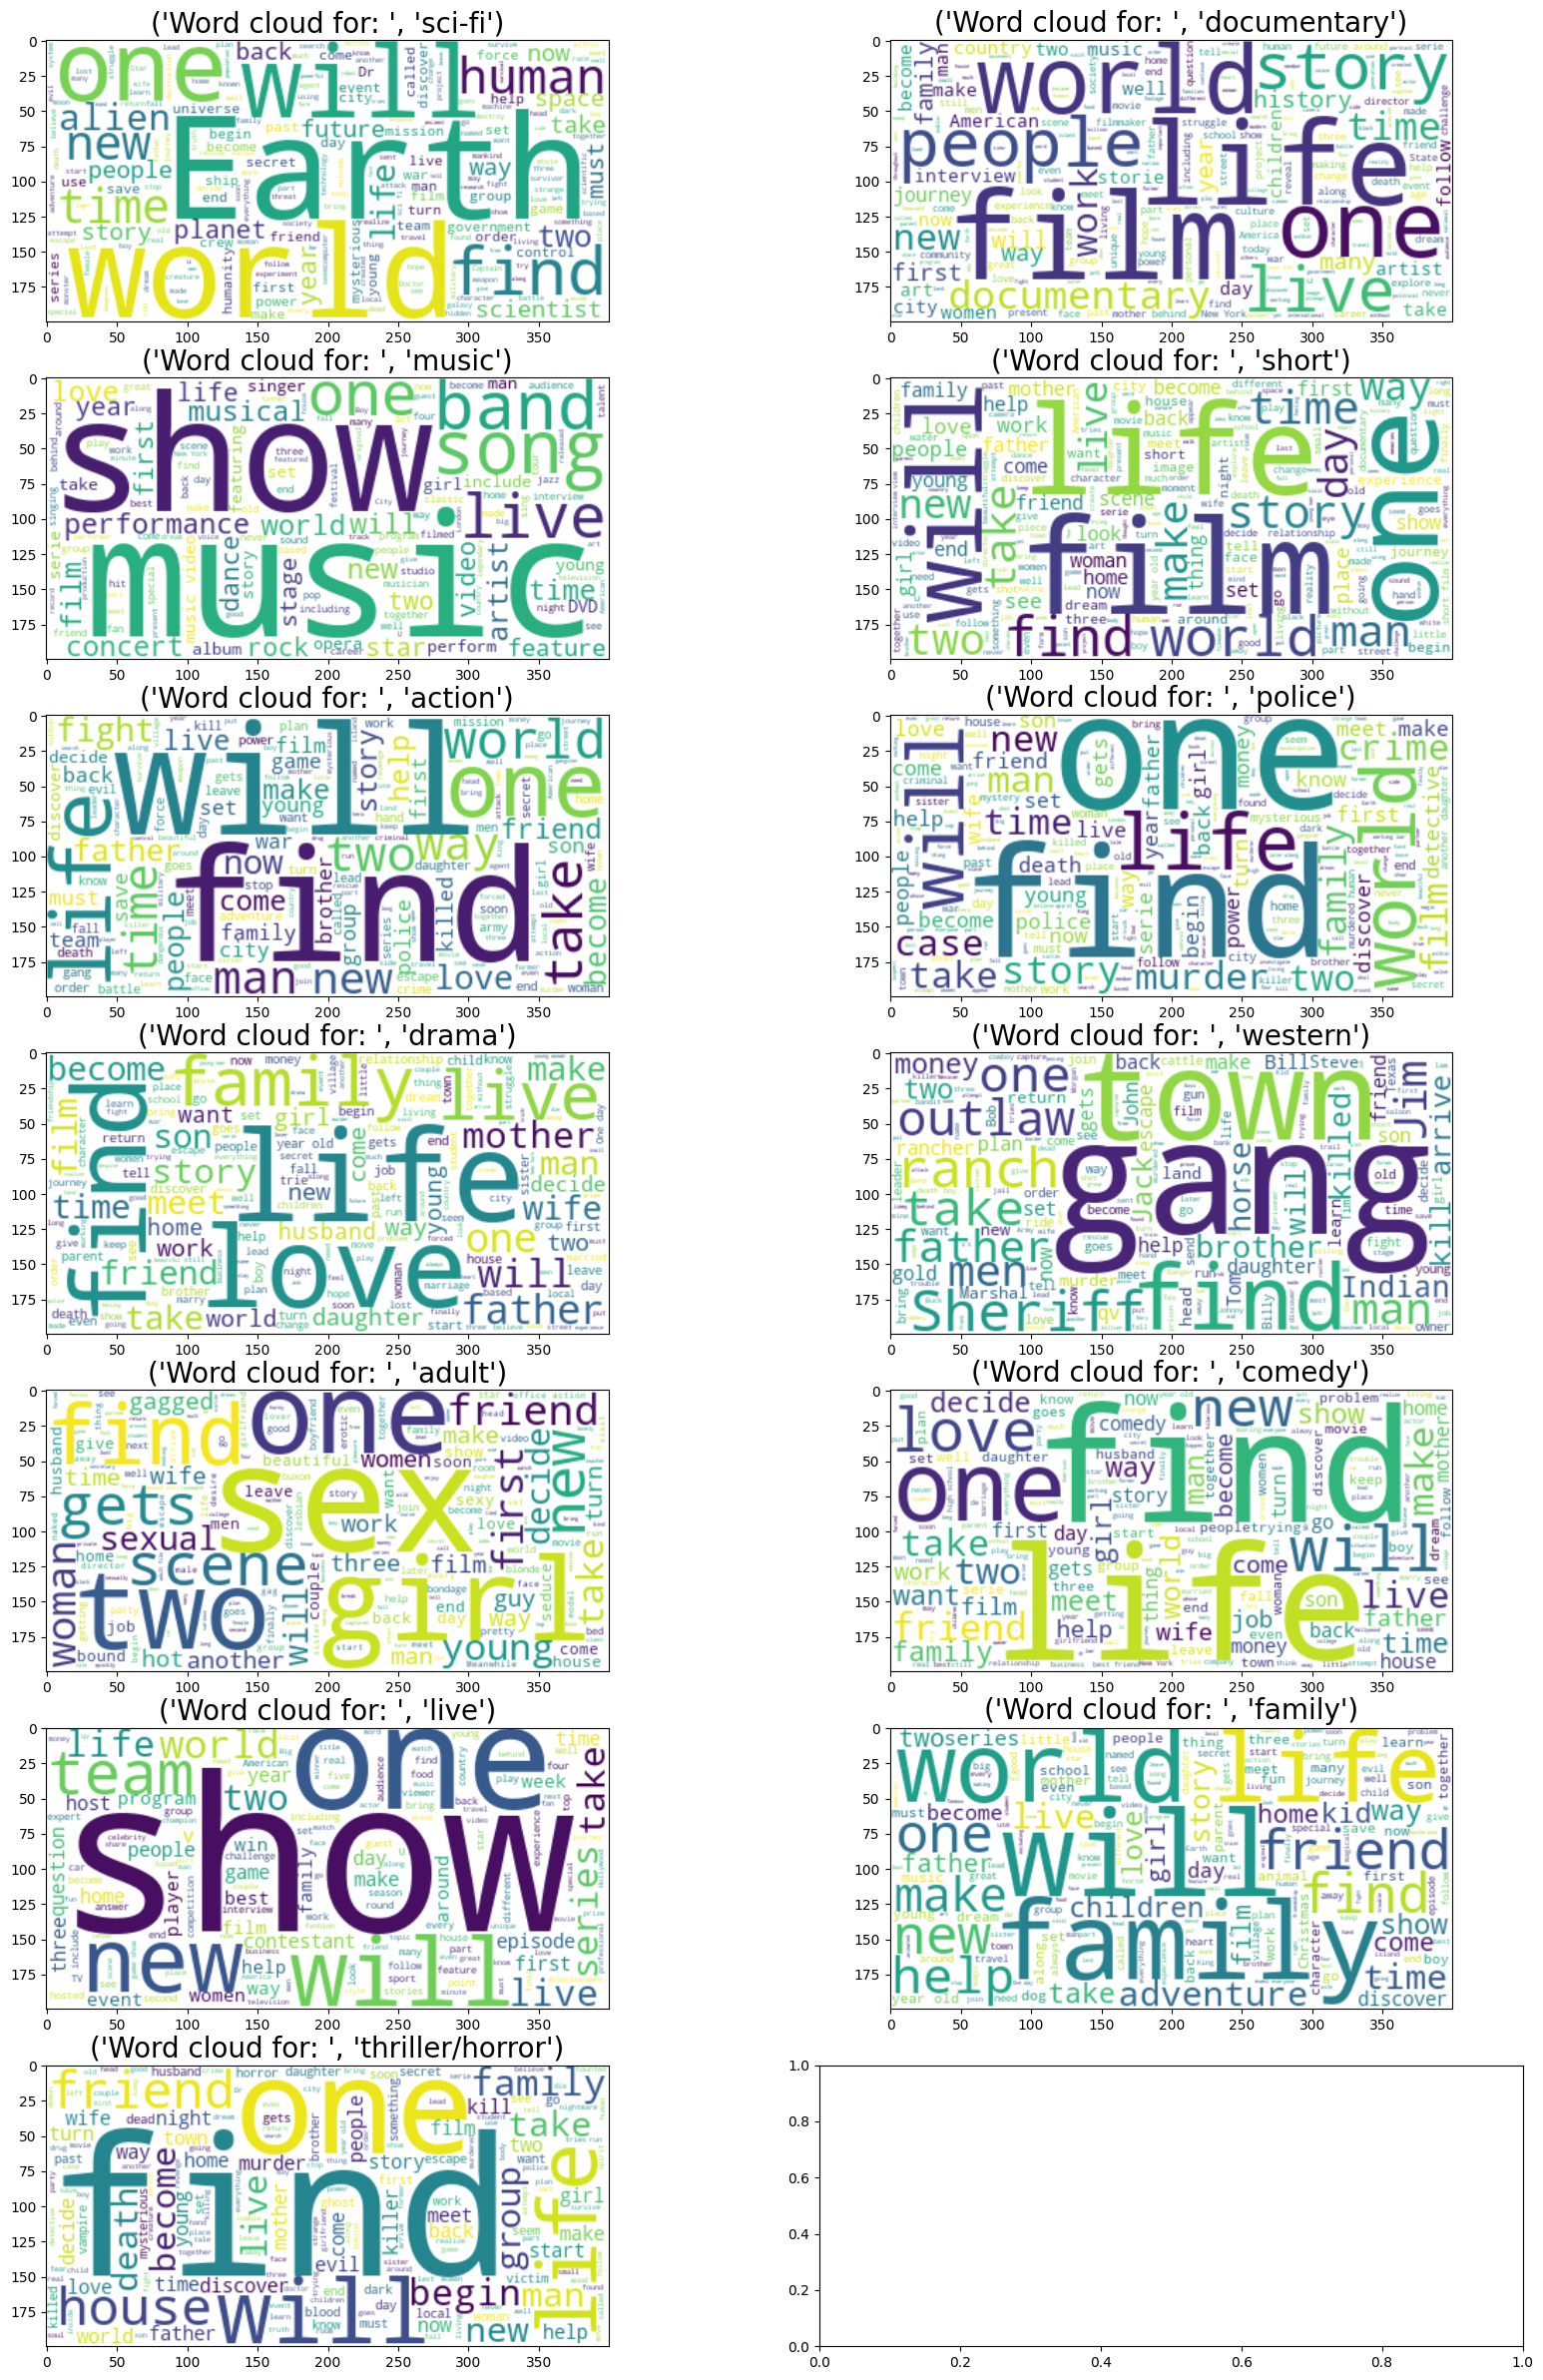

In [11]:
Genres = list(set(df_train.Genre.values))

rows=7
cols=2

fig, ax = plt.subplots(rows, cols, figsize=(20,30))

row=0 
col=0 

for t in Genres:
    positive_data = df_train[df_train['Genre'] == t]['Description']
    positive_data_string = ' '.join(positive_data)
    wc = WordCloud(max_words = 2000,background_color="white").generate(positive_data_string)
    ax[row][col].imshow(wc, interpolation = 'bilinear')
    ax[row][col].set_title(('Word cloud for: ', t), fontsize=20)
    row=row+1
    if row==rows:
        row=0
        col=col+1

plt.show()

Certain movie genres exhibit characteristic vocabulary that sets them apart from others. For instance, when examining the word cloud for the Western genre, we can observe specific terms that prominently stand out, such as "town," "gang," "sheriff,". These words are strongly associated with the Western genre due to its thematic elements. The distinctiveness of these words in the word cloud signals a clear linguistic pattern unique to Western movies.

Conversely, when analyzing word clouds for genres like Family and Short, the absence of highly distinctive words becomes apparent. Instead, common and generic terms such as "family," "life," "film," and "will" dominate the word cloud. These terms are not exclusive to any particular genre and may appear in descriptions of movies across various genres, indicating a lack of specificity in the language associated with these genres.

The implication of this observation is twofold:

Classifier Performance: Genres like Western, with their distinctive vocabulary, present clear signals that can be leveraged by classifiers for accurate genre classification. A classifier trained on textual features derived from these distinct words is likely to perform well in identifying Western movies.

Challenges in Classification: In contrast, genres like Family and Short pose challenges for classifiers due to the absence of highly distinctive words. Classifiers relying solely on textual features may struggle to accurately classify movies into these genres, as the language used to describe them lacks clear markers specific to their themes or content.

Let's see if these observations hold true.

# Preprocessing Data

In [12]:
# Download stopwords from NLTK
nltk.download('stopwords')

def preprocess_data(data):
    # Case Normalization
    data = data.lower()
    # Remove unecessary tokens
    data = re.sub(r'@\S+', '', data)
    data = re.sub(r'http\S+', '', data)
    data = re.sub(r'pic.\S+', '', data)
    data = re.sub(r"[^a-zA-Z+']", ' ', data)
    data = re.sub(r'\s+[a-zA-Z]\s+', ' ', data + ' ')
    data = "".join([i for i in data if i not in string.punctuation])
    # Tokenization
    words = nltk.word_tokenize(data)
    # Remove stop words
    stop_words = stopwords.words('english')
    tokens = " ".join([i for i in words if i not in stop_words and len(i) > 2])
    tokens = re.sub("\s[\s]+", " ", tokens).strip() # Remove repeated/leading/trailing spaces
    # Stemming & Lemmatization
    ps = PorterStemmer()
    tokens = "".join([ps.stem(i) for i in tokens])

    return tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vinic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
df_train['Tokens'] = df_train['Description'].apply(preprocess_data)
df_test['Tokens'] = df_test['Description'].apply(preprocess_data)

# Text Vectorization Using TF-IDF
vectorizer = TfidfVectorizer()

# Fit and transform the data
X_train = vectorizer.fit_transform(df_train['Tokens'])
X_test = vectorizer.transform(df_test['Tokens'])

In [14]:
# Dividing data into input (X) and target (y)
#X = df_train.Tokens.values
y = df_train.Genre.values
y_solution = solution.Genre.values

#X_test = df_test.Tokens.values

# Encoding target
label_encoder = LabelEncoder()
label_encoder.fit(y)

y_encoded = label_encoder.transform(y)
y_solution = label_encoder.transform(y_solution)

### Class imbalance can lead to biased classifiers that favor the majority class, resulting in poor performance on minority classes. By generating synthetic samples for minority classes using SMOTE, you can balance the class distribution and improve the classifier's ability to accurately predict minority genres.

In [15]:
# SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
x_res, y_res = smote.fit_resample(X_train, y)

# Naive Bayes Classifier

In [16]:
# Initialize and train a Multinomial Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(x_res, y_res)

# Stratified K Fold with 5 folds and cross validation
stratified_kfold = StratifiedKFold()
cross_val_scores = cross_val_score(classifier, x_res, y_res, cv=stratified_kfold)

# Evaluate the performance of the model
print("Cross Validation Accuracy:", cross_val_scores)
print("Mean Cross Validation Accuracy:", cross_val_scores.mean())

Cross Validation Accuracy: [0.81939097 0.84259982 0.86500094 0.87227054 0.87625535]
Mean Cross Validation Accuracy: 0.8551035244069896


### Predict on test data and compare with ground truth

In [17]:
# Use the trained model to make predictions on the test data
X_test_predictions = classifier.predict(X_test)
pred = label_encoder.transform(X_test_predictions)
# Evaluate the performance of the model
accuracy = accuracy_score(y_solution, pred)
print("Test Accuracy:", np.round(accuracy, 2))

Test Accuracy: 0.58


In [18]:
pred = label_encoder.inverse_transform(pred)
y_solution = label_encoder.inverse_transform(y_solution)
print(classification_report(y_solution, pred))

                 precision    recall  f1-score   support

         action       0.37      0.45      0.40      2221
          adult       0.41      0.64      0.50       590
         comedy       0.60      0.51      0.55      7446
    documentary       0.75      0.70      0.73     13603
          drama       0.69      0.58      0.63     14284
         family       0.33      0.35      0.34      1281
           live       0.44      0.66      0.53      2079
          music       0.36      0.67      0.47      1007
         police       0.18      0.25      0.21      1145
         sci-fi       0.32      0.57      0.41       646
          short       0.47      0.33      0.39      5072
thriller/horror       0.49      0.69      0.57      3794
        western       0.67      0.93      0.77      1032

       accuracy                           0.58     54200
      macro avg       0.47      0.56      0.50     54200
   weighted avg       0.60      0.58      0.58     54200



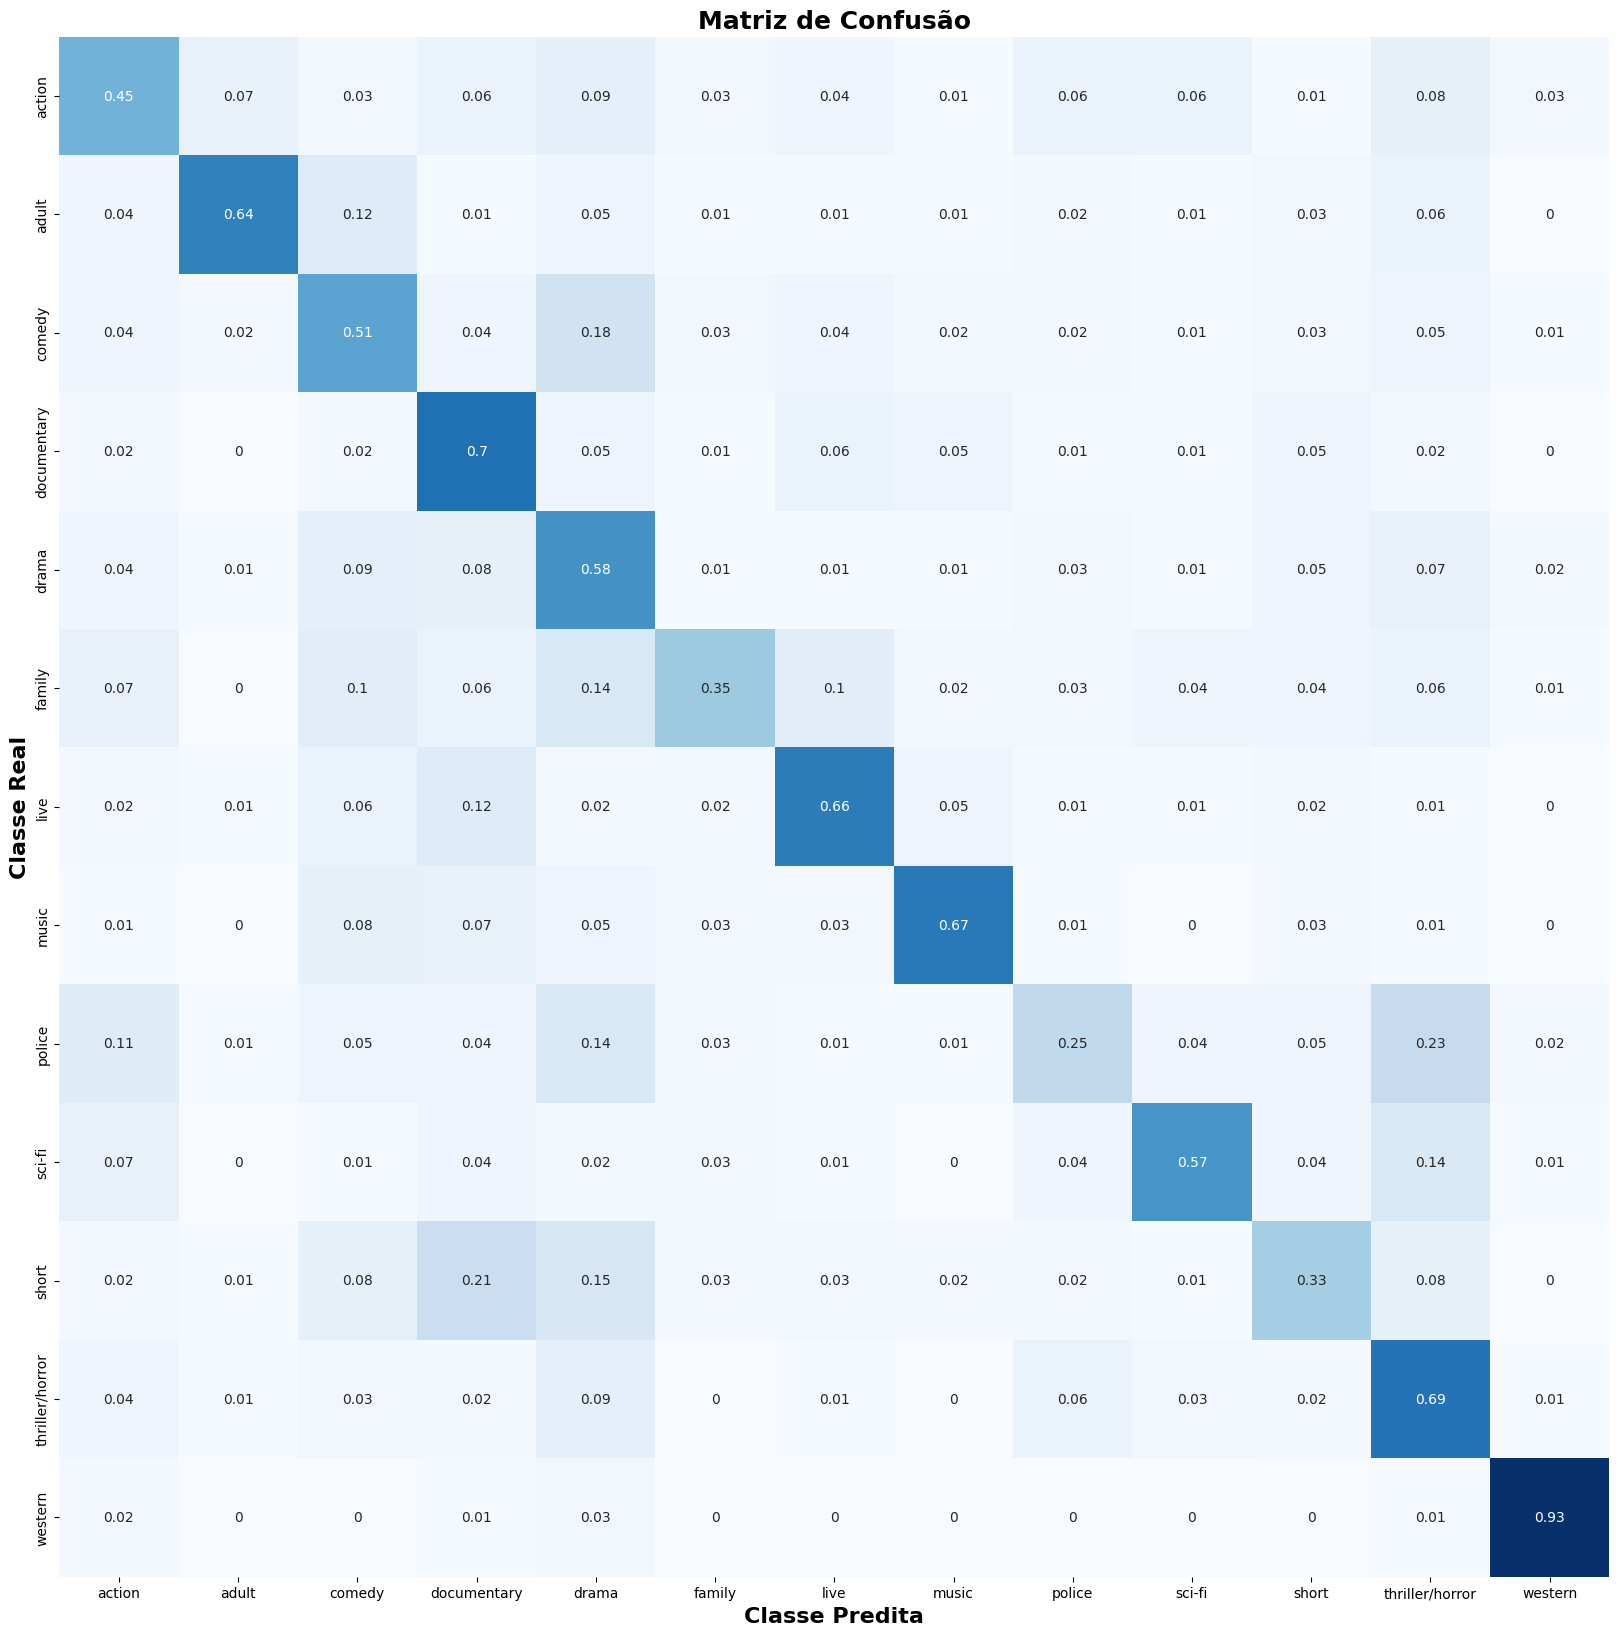

In [19]:
cm = confusion_matrix(y_solution, pred)
# Normalise
cmn = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
fig, ax = plt.subplots(figsize=(20,20))

labels = ['action', 'adult', 'comedy', 'documentary', 'drama', 'family', 'live', 'music', 'police', 
          'sci-fi', 'short', 'thriller/horror', 'western']

sns.heatmap(cmn, 
            annot=True, 
            cmap="Blues",
            cbar = False,
            xticklabels=labels,
            yticklabels=labels)


plt.title('Matriz de Confusão', fontsize=18, fontweight="bold")
plt.ylabel('Classe Real', fontsize=16, fontweight="bold")
plt.xlabel('Classe Predita', fontsize=16, fontweight="bold")
#plt.savefig("matriz_confusao_experimental", dpi=600)
plt.show(block=False)

Our observations are partially confirmed as we find that certain movie genres, such as Western, exhibit a notably high accuracy in prediction rates. Conversely, genres like Short and Family display lower prediction accuracies.

In [20]:
# Save model and vectorizer
import pickle

f = open('my_classifier.pickle', 'wb')
pickle.dump(classifier, f)
f.close()

f = open('my_vectorizer.pickle', 'wb')
pickle.dump(vectorizer, f)
f.close()

# LSTM

In [176]:
df_train['Tokens'] = df_train['Description'].apply(preprocess_data)
df_test['Tokens'] = df_test['Description'].apply(preprocess_data)

In [177]:
# Dividing data into input (X) and target (y)
X = df_train.Tokens.values
y = df_train.Genre.values
y_solution = solution.Genre.values

X_test = df_test.Tokens.values

# Encoding target
y_encoded = label_encoder.transform(y)
y_solution = label_encoder.transform(y_solution)

In [178]:
# set parameters: max no. of word in the tokenizer & max sequence length
MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 200

# prepare the Tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, oov_token="<oov>")
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
input_dim = len(word_index)
print("Vocabulary of the dataset is : ",input_dim)

Vocabulary of the dataset is :  124211


In [179]:
##create sequences of Descriptions
seq_train = tokenizer.texts_to_sequences(X)
seq_test =  tokenizer.texts_to_sequences(X_test)

#create padded sequences
pad_train=pad_sequences(seq_train,truncating = 'post', padding = 'pre',maxlen=MAX_SEQUENCE_LENGTH)
pad_test=pad_sequences(seq_test,truncating = 'post', padding = 'pre',maxlen=MAX_SEQUENCE_LENGTH)

In [180]:
x_train, x_val, y_train, y_val = train_test_split(pad_train, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [181]:
def lstm_model(x_train,x_val,y_train,y_val,input_dim,embedding_dim,maxlen,epochs):

    print("----Building the model----")
    inputs = Input(shape=(maxlen,))
    x = Embedding(input_dim + 1, embedding_dim, input_length = maxlen)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32,5,activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    output = Dense(len(set(y_encoded)), activation='sigmoid')(x)
    model = tf.keras.models.Model(inputs, output)
    model.summary()

    #Training the LSTM
    print("----Training the network----")
    model.compile(optimizer= 'adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    
    early_stop = EarlyStopping(monitor='val_accuracy', 
                               mode='min', 
                               patience = 10)
    checkpoints = ModelCheckpoint(filepath='./',
                            monitor="val_accuracy",
                            verbose=0,
                            save_best_only=True)
    reduceLR = ReduceLROnPlateau(monitor="val_acc", 
                                 factor=0.8, 
                                 patience=4, 
                                 mode="auto")
    callbacks = [checkpoints,early_stop, reduceLR]
    history = model.fit(x_train,y_train, 
                  validation_data = (x_val,y_val), 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32,
                  callbacks = callbacks)
    print("Train score:", model.evaluate(x_train,y_train))
    print("Validation score:", model.evaluate(x_val,y_val))
        
    return model, history

In [182]:
embedding_dim = 64 #embedding dims
epochs = 15
model, history = lstm_model(x_train,x_val,y_train,y_val,input_dim,embedding_dim,MAX_SEQUENCE_LENGTH,epochs)

----Building the model----
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 200, 64)           7949568   
                                                                 
 batch_normalization_5 (Bat  (None, 200, 64)           256       
 chNormalization)                                                
                                                                 
 dropout_15 (Dropout)        (None, 200, 64)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 196, 32)           10272     
                                                                 
 dropout_16 (Dropout)        (None, 196, 32)           0         
                                

INFO:tensorflow:Assets written to: .\assets


1356/1356 - 232s - loss: 1.7178 - accuracy: 0.4530 - val_loss: 1.4359 - val_accuracy: 0.5393 - lr: 0.0010 - 232s/epoch - 171ms/step
Epoch 2/15
INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


1356/1356 - 251s - loss: 1.3551 - accuracy: 0.5738 - val_loss: 1.3642 - val_accuracy: 0.5591 - lr: 0.0010 - 251s/epoch - 185ms/step
Epoch 3/15
INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


1356/1356 - 265s - loss: 1.2090 - accuracy: 0.6212 - val_loss: 1.3260 - val_accuracy: 0.5830 - lr: 0.0010 - 265s/epoch - 195ms/step
Epoch 4/15
INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


1356/1356 - 270s - loss: 1.1080 - accuracy: 0.6550 - val_loss: 1.3444 - val_accuracy: 0.5878 - lr: 0.0010 - 270s/epoch - 199ms/step
Epoch 5/15
INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


1356/1356 - 260s - loss: 1.0097 - accuracy: 0.6901 - val_loss: 1.3296 - val_accuracy: 0.5899 - lr: 0.0010 - 260s/epoch - 192ms/step
Epoch 6/15


1356/1356 - 242s - loss: 0.9356 - accuracy: 0.7123 - val_loss: 1.3742 - val_accuracy: 0.5788 - lr: 0.0010 - 242s/epoch - 178ms/step
Epoch 7/15


1356/1356 - 234s - loss: 0.8812 - accuracy: 0.7302 - val_loss: 1.4359 - val_accuracy: 0.5775 - lr: 0.0010 - 234s/epoch - 172ms/step
Epoch 8/15


1356/1356 - 234s - loss: 0.8224 - accuracy: 0.7476 - val_loss: 1.3957 - val_accuracy: 0.5804 - lr: 0.0010 - 234s/epoch - 173ms/step
Epoch 9/15


1356/1356 - 234s - loss: 0.7812 - accuracy: 0.7604 - val_loss: 1.4806 - val_accuracy: 0.5830 - lr: 0.0010 - 234s/epoch - 173ms/step
Epoch 10/15


1356/1356 - 233s - loss: 0.7441 - accuracy: 0.7731 - val_loss: 1.5424 - val_accuracy: 0.5735 - lr: 0.0010 - 233s/epoch - 172ms/step
Epoch 11/15


1356/1356 - 233s - loss: 0.7060 - accuracy: 0.7846 - val_loss: 1.5767 - val_accuracy: 0.5756 - lr: 0.0010 - 233s/epoch - 172ms/step
1356/1356 [==============================] - 86s 63ms/step - loss: 0.4244 - accuracy: 0.8747
Train score: [0.4244433641433716, 0.8746628165245056]
339/339 [==============================] - 21s 62ms/step - loss: 1.5767 - accuracy: 0.5756
Validation score: [1.5767183303833008, 0.5755786895751953]


In [183]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter( y=history.history['val_loss'], name="val_loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=history.history['loss'], name="loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=history.history['val_accuracy'], name="val accuracy"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter( y=history.history['accuracy'], name="accuracy"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Loss/Accuracy of CNN Model"
)

# Set x-axis title
fig.update_xaxes(title_text="Epoch")

# Set y-axes titles
fig.update_yaxes(title_text="Loss", secondary_y=False)
fig.update_yaxes(title_text="Accuracy", secondary_y=True)

fig.show()

In [184]:
# Evaluate the model accuracy on the test set.
score = model.evaluate(pad_test, y_solution, verbose=1)

print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

saida_rede = pd.DataFrame(model.predict(pad_test)).round(decimals = 2)
predito   = saida_rede.idxmax(axis=1)
avaliado  = pd.DataFrame(y_solution).iloc[:, 0]

score = accuracy_score(avaliado, predito)
print('Acurácia Teste')
print(score)


print("f1:",f1_score(y_solution, predito,average='micro'))

print ("precision:",precision_score(y_solution, predito,average='macro'))

print ("recall:",recall_score(y_solution, predito,average='macro'))

1694/1694 [==============================] - 104s 61ms/step - loss: 1.5790 - accuracy: 0.5722
accuracy: 57.22%
1694/1694 [==============================] - 113s 65ms/step
Acurácia Teste
0.5715129151291513
f1: 0.5715129151291513
precision: 0.4557516078363891
recall: 0.4179995050023132


In [185]:
pred = label_encoder.inverse_transform(predito)
y_solution = label_encoder.inverse_transform(y_solution)
print(classification_report(y_solution, pred))

                 precision    recall  f1-score   support

         action       0.35      0.32      0.33      2221
          adult       0.42      0.24      0.31       590
         comedy       0.48      0.61      0.53      7446
    documentary       0.71      0.78      0.75     13603
          drama       0.60      0.62      0.61     14284
         family       0.26      0.15      0.19      1281
           live       0.52      0.43      0.47      2079
          music       0.51      0.44      0.47      1007
         police       0.09      0.00      0.01      1145
         sci-fi       0.30      0.23      0.26       646
          short       0.41      0.30      0.35      5072
thriller/horror       0.53      0.56      0.55      3794
        western       0.76      0.76      0.76      1032

       accuracy                           0.57     54200
      macro avg       0.46      0.42      0.43     54200
   weighted avg       0.55      0.57      0.56     54200



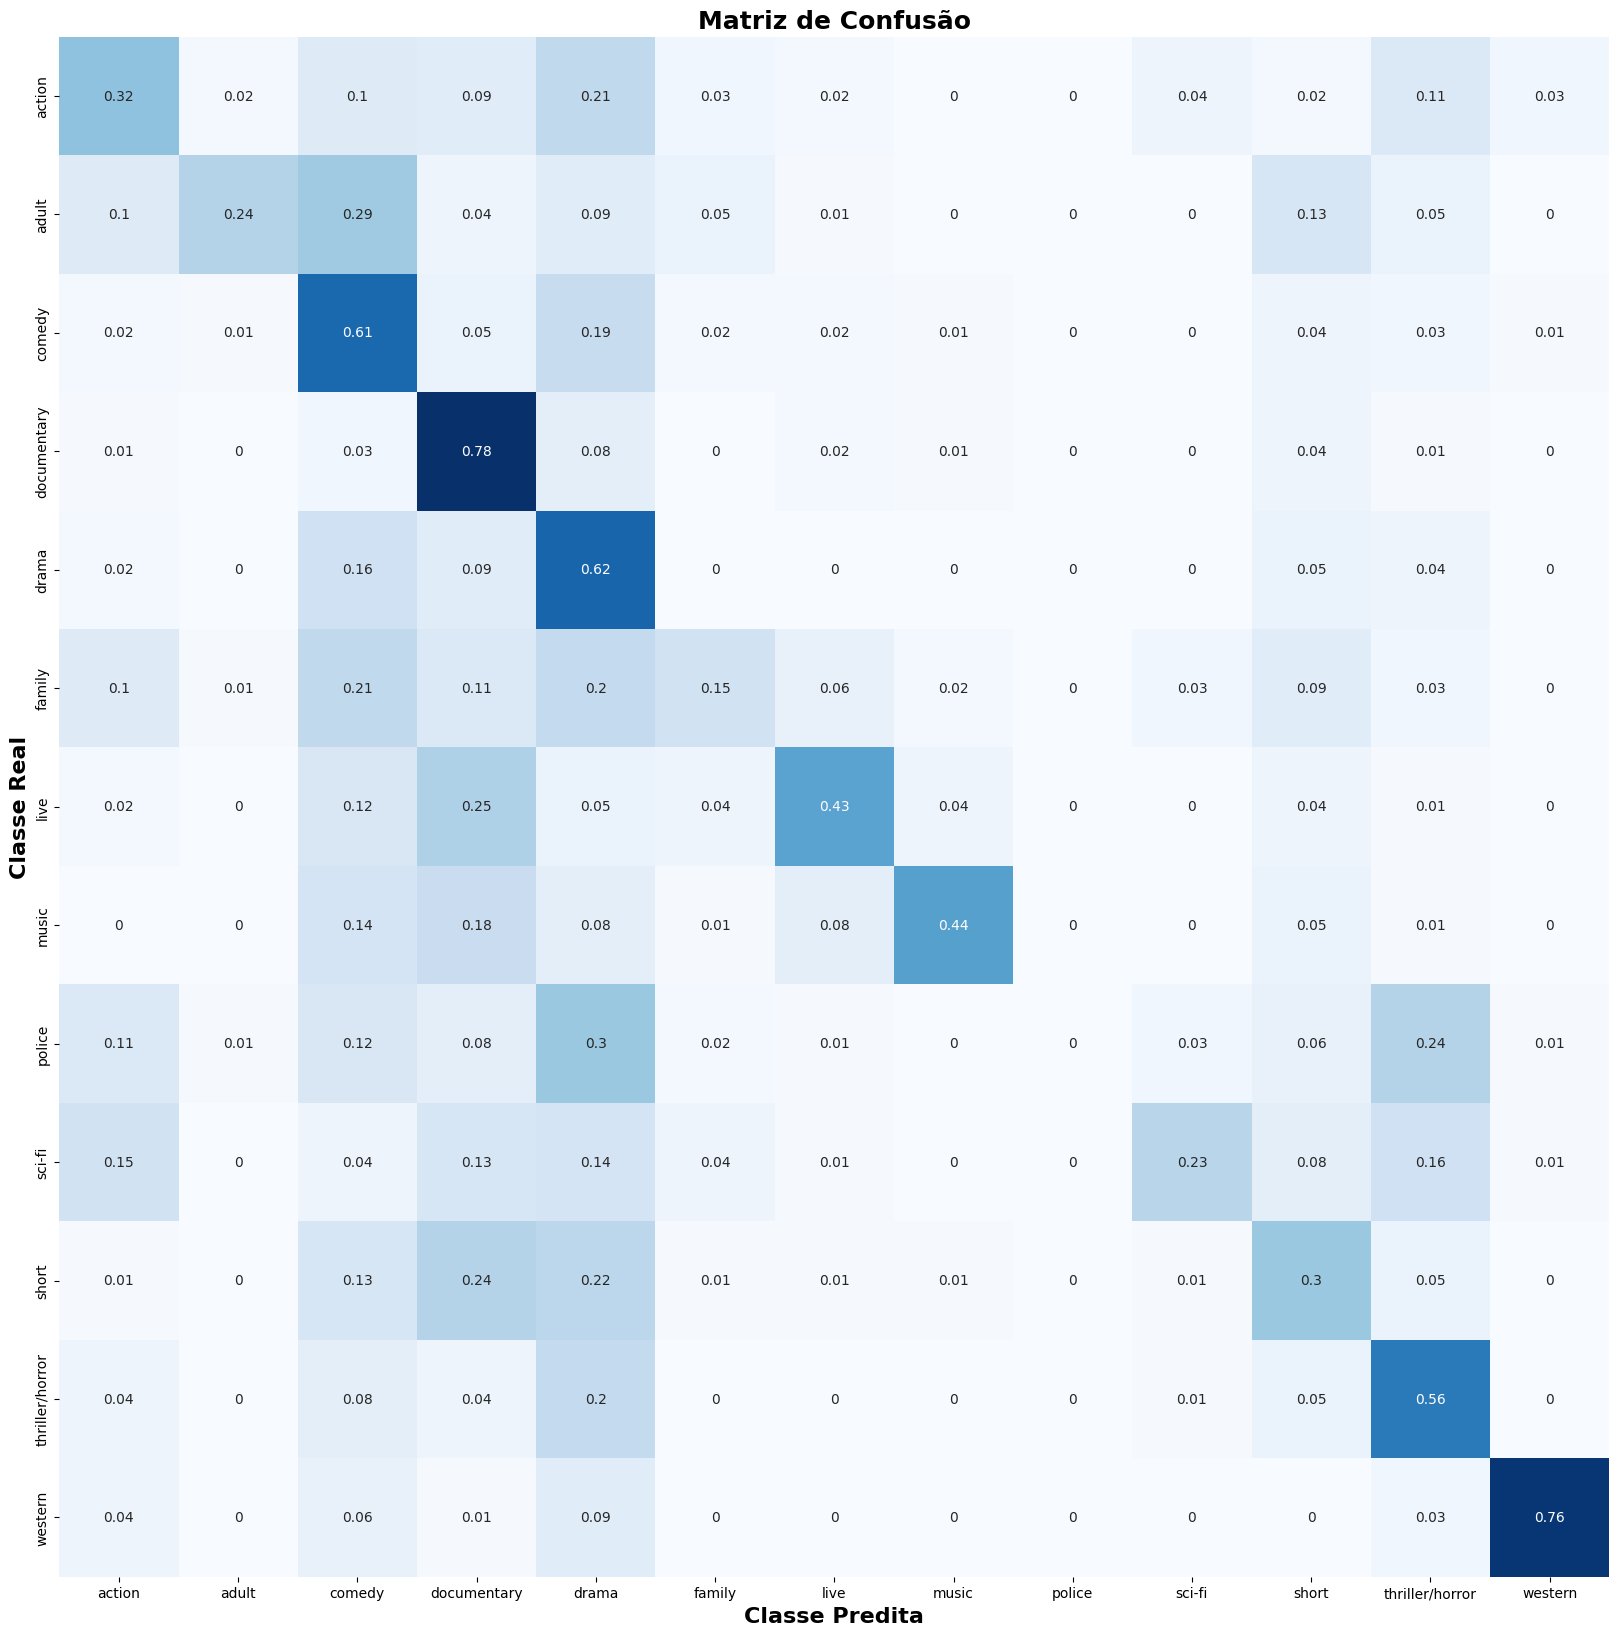

In [186]:
cm = confusion_matrix(y_solution, pred)
# Normalise
cmn = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
fig, ax = plt.subplots(figsize=(20,20))

labels = ['action', 'adult', 'comedy', 'documentary', 'drama', 'family', 'live', 'music', 'police', 
          'sci-fi', 'short', 'thriller/horror', 'western']

sns.heatmap(cmn, 
            annot=True, 
            cmap="Blues",
            cbar = False,
            xticklabels=labels,
            yticklabels=labels)


plt.title('Matriz de Confusão', fontsize=18, fontweight="bold")
plt.ylabel('Classe Real', fontsize=16, fontweight="bold")
plt.xlabel('Classe Predita', fontsize=16, fontweight="bold")
#plt.savefig("matriz_confusao_experimental", dpi=600)
plt.show(block=False)

Incorporating LSTM (Long Short-Term Memory) architecture did not lead to a notable enhancement in the performance of our movie genre classification model. Consequently, we have decided to pivot towards utilizing Naive Bayes instead.

Naive Bayes classifiers are renowned for their simplicity and computational efficiency. Unlike LSTM models, which are complex recurrent neural networks requiring significant computational resources and longer training times, Naive Bayes classifiers are lightweight and can be trained quickly even on large datasets.

# Gradio

Creating a Gradio app interface for interacting with the movie genre classification model introduces a user-friendly and accessible way to utilize the model's capabilities. Gradio allows users to interact with machine learning models through intuitive interfaces, enabling seamless input and output interactions without requiring any coding expertise.

You can access through the link below:

https://huggingface.co/spaces/viniciusanm/movie-genre-classification